# Telco Churn Prediction

## 0 · Requirments

In [1]:
%pip install -q pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost jupyterlab

Note: you may need to restart the kernel to use updated packages.


## 1 · Setup

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.combine import SMOTEENN
import warnings, matplotlib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (8,5)

## 2 · Data Snapshot

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [5]:
for c in df.select_dtypes('object').columns:
    print(c, df[c].unique()[:5], '...')

gender ['Female' 'Male'] ...
Partner ['Yes' 'No'] ...
Dependents ['No' 'Yes'] ...
PhoneService ['No' 'Yes'] ...
MultipleLines ['No phone service' 'No' 'Yes'] ...
InternetService ['DSL' 'Fiber optic' 'No'] ...
OnlineSecurity ['No' 'Yes' 'No internet service'] ...
OnlineBackup ['Yes' 'No' 'No internet service'] ...
DeviceProtection ['No' 'Yes' 'No internet service'] ...
TechSupport ['No' 'Yes' 'No internet service'] ...
StreamingTV ['No' 'Yes' 'No internet service'] ...
StreamingMovies ['No' 'Yes' 'No internet service'] ...
Contract ['Month-to-month' 'One year' 'Two year'] ...
PaperlessBilling ['Yes' 'No'] ...
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] ...
Churn ['No' 'Yes'] ...


Text(0.5, 1.0, 'Missing‑value map')

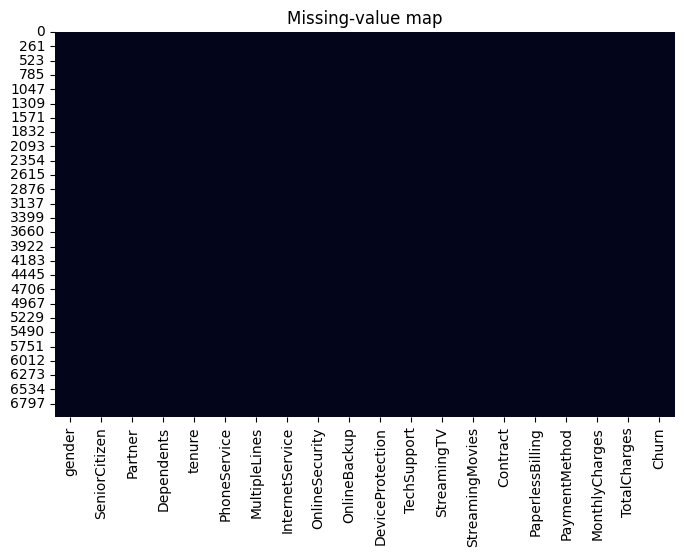

In [7]:
sns.heatmap(df.isnull(), cbar=False); plt.title('Missing‑value map')

## 3 · Cleaning & Preparation

In [ ]:
categorical_cols = df.select_dtypes(include=['category', 'object']).columns

# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Setting drop='first' to avoid multicollinearity
encoded_data = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

df.drop(columns=categorical_cols, inplace=True)

df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_df], axis=1)

In [16]:
df.drop('Churn_No', axis=1, inplace=True)

In [ ]:
df.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

## 4 · Explorations

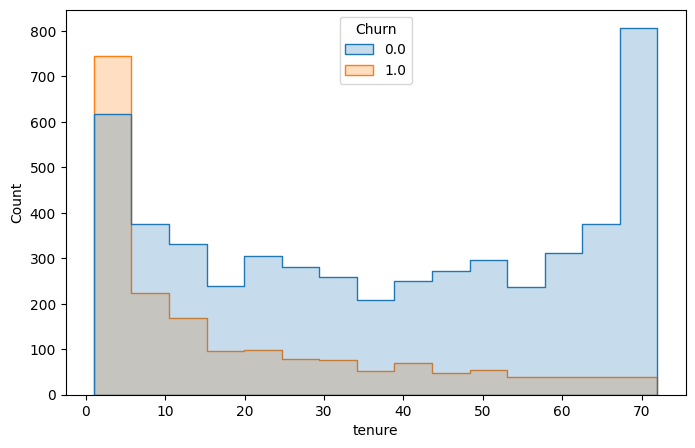

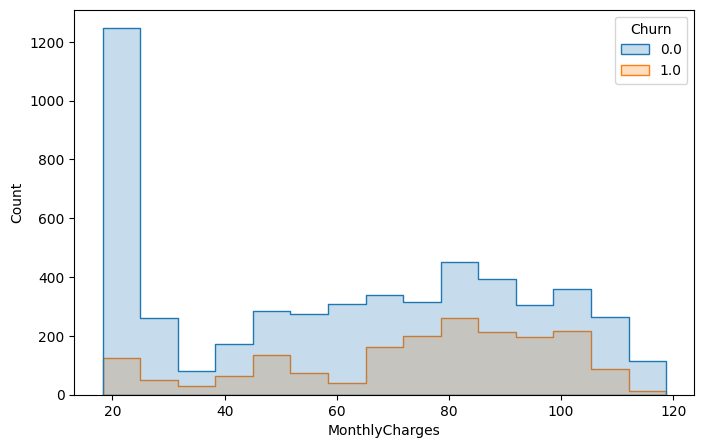

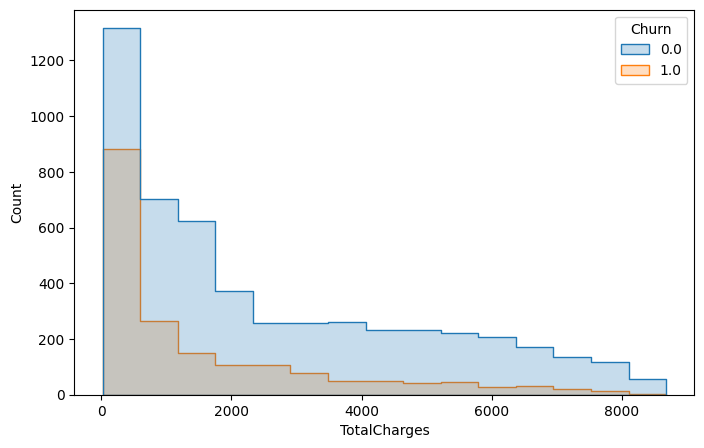

In [19]:
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    sns.histplot(data=df, x=col, hue='Churn', bins=15, element='step'); plt.show()

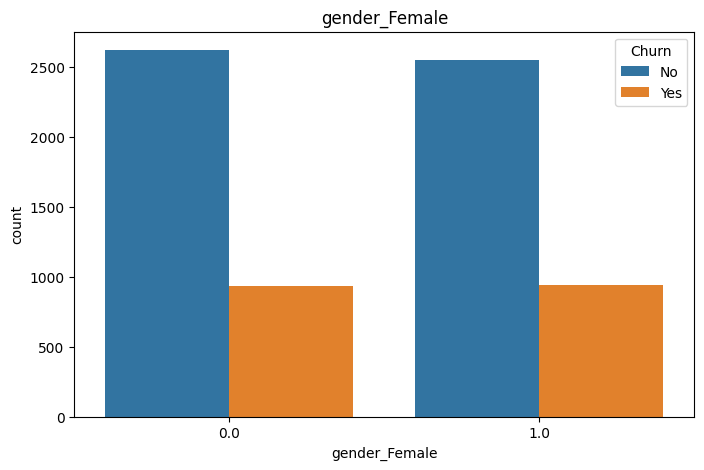

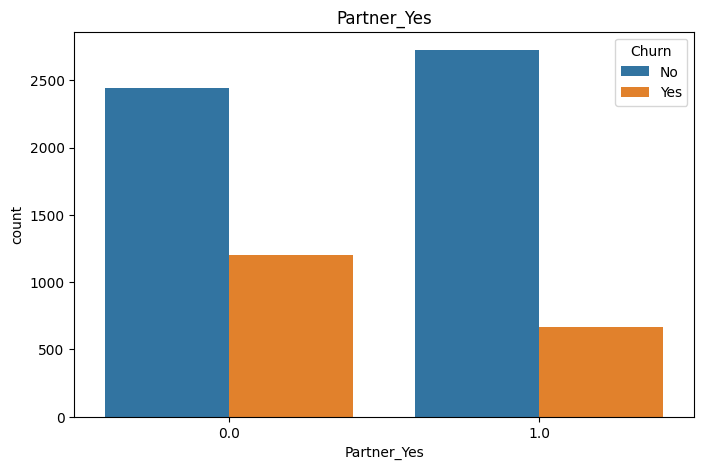

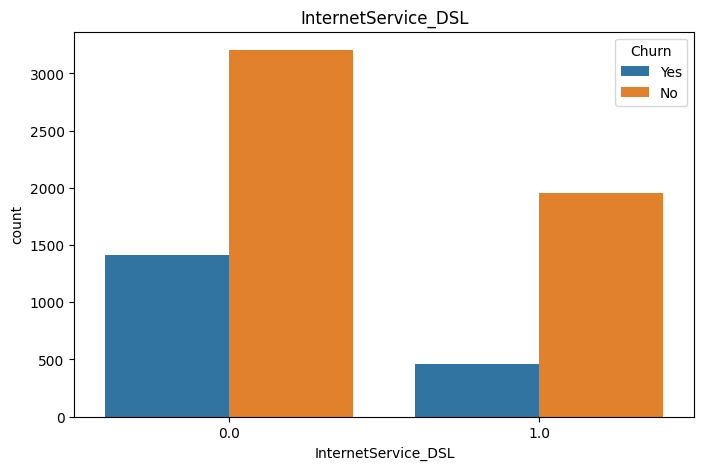

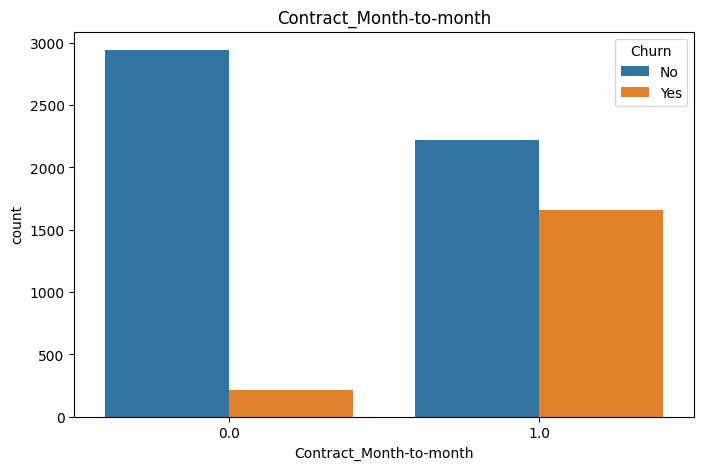

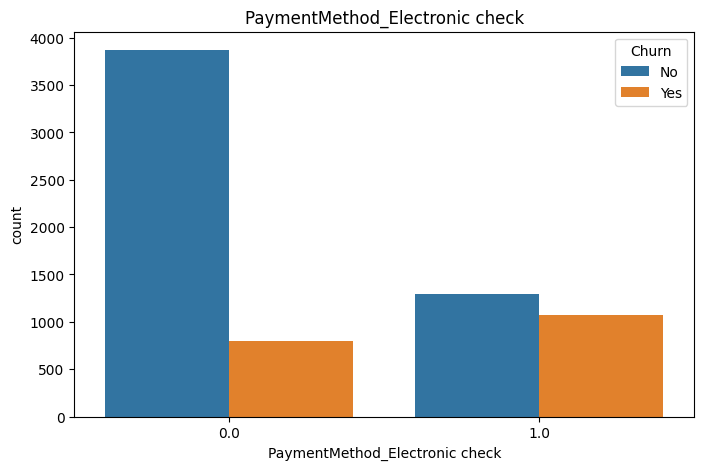

In [11]:
for col in ['gender_Female','Partner_Yes','InternetService_DSL',
            'Contract_Month-to-month','PaymentMethod_Electronic check']:
    sns.countplot(x=df[col], hue=y.map({0:'No',1:'Yes'})); plt.title(col); plt.show()

## 5 · Baseline Models

In [21]:
models = [
    ('Random Forest', RandomForestClassifier(), 
     {'model__n_estimators':[50,100], 'model__max_depth':[None,10]}),
    ('Gradient Boosting', GradientBoostingClassifier(),
     {'model__n_estimators':[100], 'model__learning_rate':[0.1]}),
    ('SVM', SVC(class_weight='balanced'), {'model__C':[1,10],'model__gamma':['scale']}),
    ('LogReg', LogisticRegression(class_weight='balanced'),
     {'model__C':[1],'model__penalty':['l2']}),
    ('KNN', KNeighborsClassifier(), {'model__n_neighbors':[5]}),
    ('Decision Tree', DecisionTreeClassifier(), {'model__max_depth':[None,10]}),
    ('AdaBoost', AdaBoostClassifier(), {'model__n_estimators':[100]}),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
     {'model__n_estimators':[100],'model__learning_rate':[0.1]}),
    ('Naive Bayes', GaussianNB(), {})
]

scores = []
best_pipe, best_acc = None, 0
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, stratify=y)

for name, mdl, grid in models:
    pipe = Pipeline([('scaler', MinMaxScaler()), ('model', mdl)])
    if grid:
        pipe = GridSearchCV(pipe, param_grid=grid, cv=2)
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    acc = accuracy_score(y_te, pred)
    scores.append((name, acc))
    if acc>best_acc: best_acc, best_pipe = acc, pipe.best_estimator_ if grid else pipe

pd.DataFrame(scores, columns=['Model','Accuracy']).sort_values('Accuracy',ascending=False)

,Model,Accuracy
1,Gradient Boosting,0.821606
6,AdaBoost,0.809524
0,Random Forest,0.808102
7,XGBoost,0.803127
5,Decision Tree,0.775409
4,KNN,0.751244
3,LogReg,0.735608
2,SVM,0.732765
8,Naive Bayes,0.678749


## 6 · Resampling + Tuning

In [22]:
sm = SMOTEENN()
X_res, y_res = sm.fit_resample(X, y)
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_res, y_res, test_size=.2, stratify=y_res)

models_rs = [
    ('Random Forest', RandomForestClassifier(), {'n_estimators':[100], 'max_depth':[None]}),
    ('Gradient Boosting', GradientBoostingClassifier(), {'n_estimators':[100]}),
    ('SVM', SVC(class_weight='balanced'), {'C':[1]}),
    ('LogReg', LogisticRegression(class_weight='balanced'), {'C':[1]}),
    ('KNN', KNeighborsClassifier(), {'n_neighbors':[3]}),
    ('Decision Tree', DecisionTreeClassifier(), {'max_depth':[None]}),
    ('AdaBoost', AdaBoostClassifier(), {'n_estimators':[100]}),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
     {'n_estimators':[200], 'learning_rate':[0.1]}),
    ('Naive Bayes', GaussianNB(), {})
]

scores_rs, best_pipe_rs, best_acc_rs = [], None, 0
for name, mdl, grid in models_rs:
    if grid:
        mdl = RandomizedSearchCV(mdl, param_distributions=grid, n_iter=5, cv=2, n_jobs=-1)
    mdl.fit(Xr_tr, yr_tr)
    pred = mdl.predict(Xr_te)
    acc = accuracy_score(yr_te, pred)
    scores_rs.append((name, acc))
    if acc > best_acc_rs: best_acc_rs, best_pipe_rs = acc, mdl

scores_rs_df = pd.DataFrame(scores_rs, columns=['Model','Accuracy']).sort_values('Accuracy',ascending=False)
scores_rs_df

,Model,Accuracy
4,KNN,0.973527
0,Random Forest,0.957301
1,Gradient Boosting,0.956447
7,XGBoost,0.956447
6,AdaBoost,0.946200
5,Decision Tree,0.921435
3,LogReg,0.912041
8,Naive Bayes,0.888984
2,SVM,0.809564


## 7 · Results

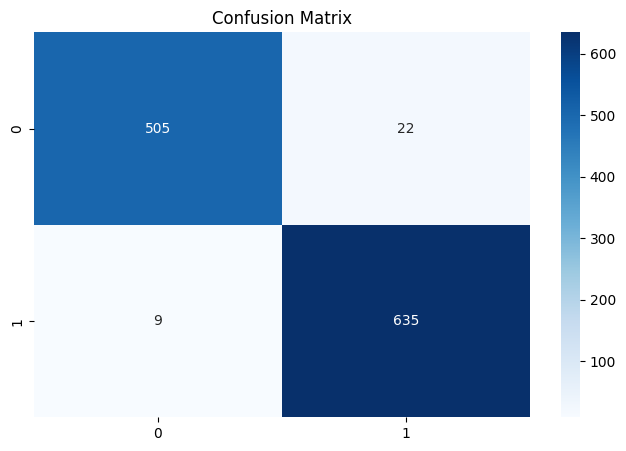

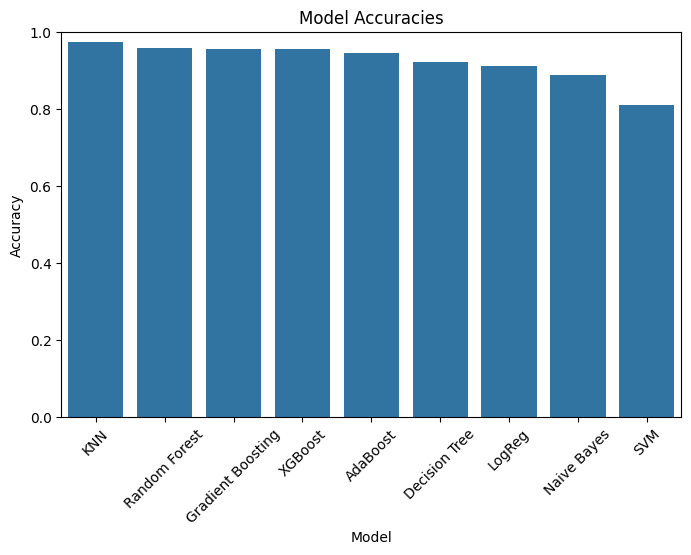

In [23]:
final_pred = best_pipe_rs.predict(Xr_te)
conf = confusion_matrix(yr_te, final_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix'); plt.show()

sns.barplot(x='Model', y='Accuracy', data=scores_rs_df)
plt.xticks(rotation=45); plt.ylim(0,1); plt.title('Model Accuracies'); plt.show()